## Imports

In [1]:
#Reading and writing data onto harddrive
import os
#To perform mathematical operations
import numpy as np
#To analyze data
import pandas as pd
#To use machine learning
import tensorflow
import tensorflow.keras
#To use camera
import cv2
#To classify camera input
from cvzone.HandTrackingModule import HandDetector
from cvzone.ClassificationModule import Classifier
#Perform basic math operations
import math
#Perform time operations
import time

# Making Directories for each sign to store data for static images for single hands

In [2]:
from functools import partial
signs = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
root_dir_left = 'Data\Left'
root_dir_right = 'Data\Right'
concat_root_path_right = partial(os.path.join, root_dir_right)
concat_root_path_left = partial(os.path.join, root_dir_left)
make_dirs = partial(os.makedirs, exist_ok=True)
for path_items in map(concat_root_path_right, signs):
    if not os.path.exists(path_items):
        make_dirs(path_items)
for path_items in map(concat_root_path_left, signs):
    if not os.path.exists(path_items):
        make_dirs(path_items)

# Taking in data for single hand inputs

In [ ]:
cap = cv2.VideoCapture(0)
detector = HandDetector(maxHands=1)


signs = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
dirhands = ["Right", "Left"]
offset = 20
imgSize = 300

i = 0

qpressed = False
while i<2:
    counter = 0
    j=0
    while j<24:
        folder = "Data/"+dirhands[i]+"/"+signs[j]
        success, img = cap.read()
        hands, img = detector.findHands(img)
        cv2.putText(img, f"{dirhands[i]}-{signs[j]}({counter})", (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        if hands:
            hand = hands[0]
            x,y,w,h = hand['bbox']
            hand_type = hand['type']
            imgWhite = np.ones((imgSize,imgSize, 3),np.uint8)*255
            imgCrop = img[y-offset:y+h+offset, x-offset:x+w+offset]

            aspectRatio = h/w
            try:
                if aspectRatio > 1:
                    k = imgSize/h
                    wCal = math.ceil(k*w)
                    imgResize = cv2.resize(imgCrop, (wCal,imgSize))
                    wGap = math.ceil((imgSize-wCal)/2)
                    imgWhite[:,wGap:wCal+wGap] = imgResize
                else:
                    k = imgSize/w
                    hCal = math.ceil(k*h)
                    imgResize = cv2.resize(imgCrop, (imgSize, hCal))
                    hGap = math.ceil((imgSize-hCal)/2)
                    imgWhite[hGap:hCal+hGap,:] = imgResize
            except:
                pass
        cv2.imshow("Maurj Feed", img)
        key = cv2.waitKey(1)
        if key == ord("s"):
            counter += 1
            cv2.imwrite(f"{folder}/{signs[j]}_{time.time()}.jpg", imgWhite)
        if key == ord('q'):
            qpressed = True
            break
        if key == ord("d"):
            j+=1
            counter=0
    i+=1
    if qpressed:
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# Setting up Directories

In [3]:
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
dirhands = ["Right", "Left"]

# Preprocessing Data(change path to switch hands)

In [10]:
#image processing converting images in arrays
x_data =[]
y_data = []
import cv2
for label in labels:
    path = f'Data/Left/{label}/'
    folder_data = os.listdir(path)
    for image_path in folder_data:
        image = cv2.imread(path+image_path)
        image_resized = cv2.resize(image, (300,300))
        x_data.append(np.array(image_resized))
        y_data.append(label)
x_data = np.array(x_data)
y_data = np.array(y_data)
#stadardizing the input data
x_data = x_data.astype('float32')/255
#converting the y_data into categorical:
from sklearn.preprocessing import LabelEncoder
y_encoded = LabelEncoder().fit_transform(y_data)

In [8]:
#Creating categorical data
from tensorflow import keras
from keras.utils import np_utils as ku

In [11]:
y_categorical = ku.to_categorical(y_encoded)
#lets shuffle all the data we have:
r = np.arange(x_data.shape[0])
np.random.seed(42)
np.random.shuffle(r)
X = x_data[r]
Y = y_categorical[r]
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# Creating Model

In [12]:
# Initialing the CNN
#from tensorflow_core.python.keras.api.keras import optimizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation

In [9]:
#Kernel = zeros --> No change in weights... like vanishing gradient problem
#kernel = random --> Performs better but when you rerun the experiment the results may vary quite a bit, depends on the application. 
#kernel = he_uniform --> Ideal to work with relu. 
#kernel = glorot_uniform --> similar to he_uniform but different variance. he_uniform is preferred with ReLu
classifier =  Sequential()


# Step 1 - Convolution Layer
classifier.add(Conv2D(filters=32, kernel_size=3, padding="same", input_shape=(300, 300, 3), activation='relu'))
# step 2 - Pooling
classifier.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Adding second convolution layer
classifier.add(Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Adding 3rd Convolution Layer
classifier.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
classifier.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full Connection
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))
#Units here are number of signs being trained
classifier.add(Dense(units=24, activation='softmax'))

# Compiling The CNN
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()
history = classifier.fit(X_train, Y_train, epochs=10, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0

# Saving and Loading Model

In [10]:
classifier.save('righthandmodel.h5')

In [13]:
#Reload an existing model
classifier = keras.models.load_model('righthandmodel.h5')

In [10]:
classifier.save('lefthandmodel.h5')

In [14]:
#Reload an existing model
classifier = keras.models.load_model('lefthandmodel.h5')

# Statistical Data on model

In [11]:
#Display of the accuracy and the loss values(Requires model to be trained for history)
import matplotlib.pyplot as plt

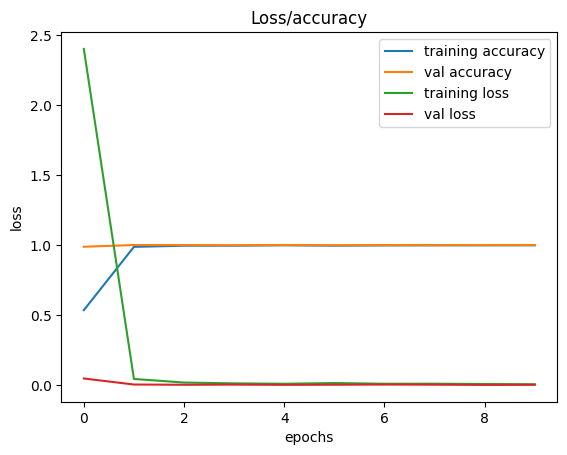

In [12]:
plt.figure()
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss/accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

C:\Users\ninja\miniconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


the accuracy obtained on the test set is: 0.9993738259236068
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        61
           5       1.00      1.00      1.00        75
           6       1.00      1.00      1.00        66
           7       1.00      1.00      1.00        68
           8       1.00      1.00      1.00        61
           9       1.00      1.00      1.00        82
          10       1.00      1.00      1.00        76
          11       1.00      1.00      1.00        54
          12       1.00      0.99      0.99        71
          13       1.00      1.00      1.00        65
          14       1.00      1.00      1.00        58
          15       1.00      1.00      1.00        60
          16       1

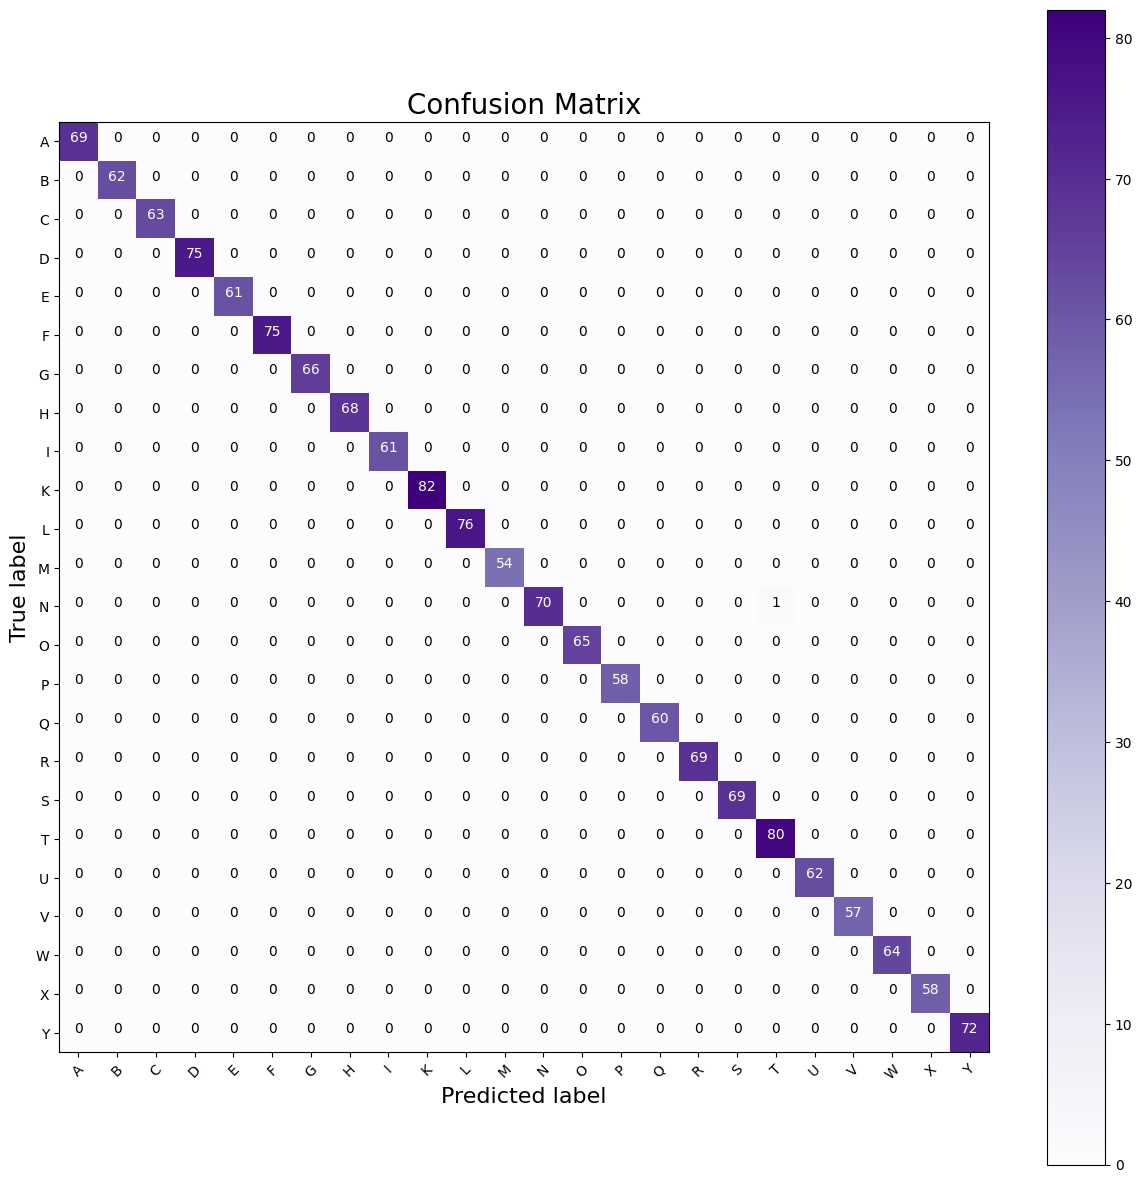

In [13]:
Y_pred = classifier.predict_classes(X_test)
Y_test = np.argmax(Y_test, axis = 1)
from sklearn.metrics import accuracy_score
print('the accuracy obtained on the test set is:', accuracy_score(Y_pred,Y_test))
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (15, 15))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = classifier.predict(X_test, batch_size = 32, verbose = 0)
plot_confusion_matrix(Y_test, Y_pred)